# Persoalan 4
Carilah data transaksi peminjaman, lalu lakukan clustering data perilaku pemijaman dan pengembalian. Kemudian hitunglah performanya.

## Package

In [555]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer, LabelEncoder, StandardScaler
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import numpy as np

In [556]:
# Load dataset
df = pd.read_csv('../dataset/credit_train.csv')

In [557]:
# Drop non-numeric columns for clustering purposes
def preprocess_data(df):
    df.drop_duplicates(inplace=True)

    # Handle categorical columns
    df['Loan Status'] = df['Loan Status'].astype('category')
    df['Term'] = df['Term'].astype('category')
    df['Years in current job'] = df['Years in current job'].astype('category')
    df['Home Ownership'] = df['Home Ownership'].astype('category')

    if 'Purpose' in df.columns:
        category_mapping = {
            'home improvements': 'home',
            'debt consolidation': 'debt',
            'buy house': 'housing',
            'business loan': 'business',
            'buy a car': 'vehicle',
            'major purchase': 'other',
            'take a trip': 'leisure',
            'other': 'other',
            'small business': 'business',
            'medical bills': 'medical',
            'wedding': 'leisure',
            'vacation': 'leisure',
            'educational expenses': 'education',
            'moving': 'housing',
            'renewable energy': 'energy'
        }
        df['Purpose'] = df['Purpose'].str.lower().replace('_', ' ').map(category_mapping).fillna('other')
        df['Purpose'] = df['Purpose'].astype('category')

    # Fill missing values
    df.fillna({
        'Months since last delinquent': df['Months since last delinquent'].mean(),
        'Current Loan Amount': df['Current Loan Amount'].mean(),
        'Monthly Debt': df['Monthly Debt'].mean(),
        'Years of Credit History': df['Years of Credit History'].mean(),
        'Credit Score': 0,
        'Annual Income': 0,
        'Number of Open Accounts': 0,
        'Number of Credit Problems': 0,
        'Current Credit Balance': 0,
        'Maximum Open Credit': 0,
        'Bankruptcies': 0,
        'Tax Liens': 0
    }, inplace=True)

    # Drop non-numeric identifiers for clustering
    df.drop(columns=['Loan ID', 'Customer ID'], inplace=True, errors='ignore')

    return df

df = preprocess_data(df)

In [558]:
# Encode Categorical Data
def encode_categorical_columns(df):
    categorical_columns = df.select_dtypes(include=['category']).columns
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col].astype(str))
        label_encoders[col] = le
    return df, label_encoders

df, label_encoders = encode_categorical_columns(df)

EDA Summary
        Loan Status  Current Loan Amount          Term  Credit Score  \
count  89786.000000         8.978600e+04  89786.000000  89786.000000   
mean       0.747867         1.306089e+07      0.735360    889.578509   
std        0.434265         3.329537e+07      0.441169   1468.403643   
min        0.000000         1.080200e+04      0.000000      0.000000   
25%        0.000000         1.802680e+05      0.000000    662.000000   
50%        1.000000         3.138740e+05      1.000000    719.000000   
75%        1.000000         5.324275e+05      1.000000    739.000000   
max        2.000000         1.000000e+08      2.000000   7510.000000   

       Annual Income  Years in current job  Home Ownership       Purpose  \
count   8.978600e+04          89786.000000    89786.000000  89786.000000   
mean    1.082360e+06              4.066391        1.932540      1.884481   
std     1.130479e+06              3.437178        0.954091      2.015659   
min     0.000000e+00              0

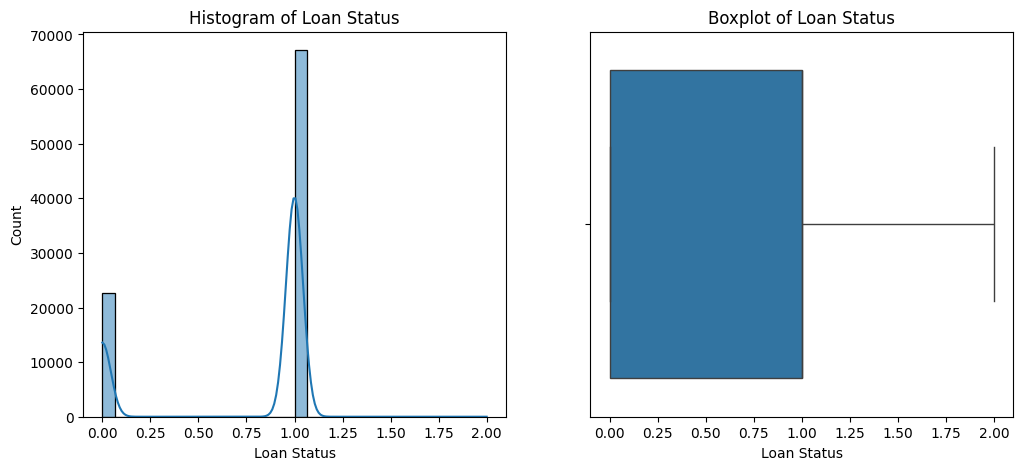

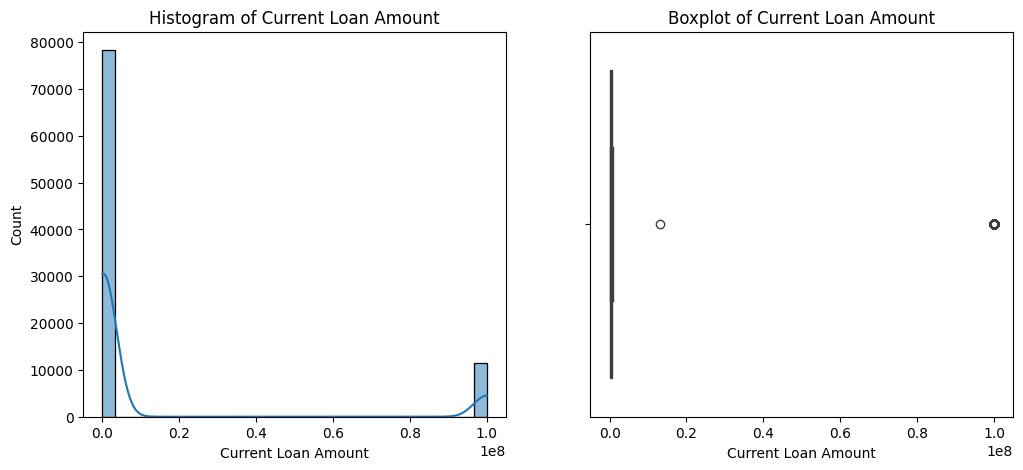

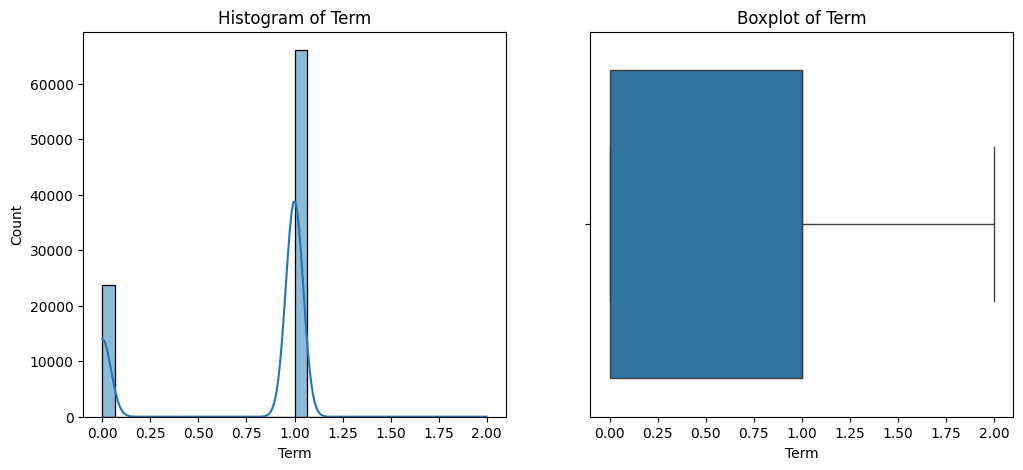

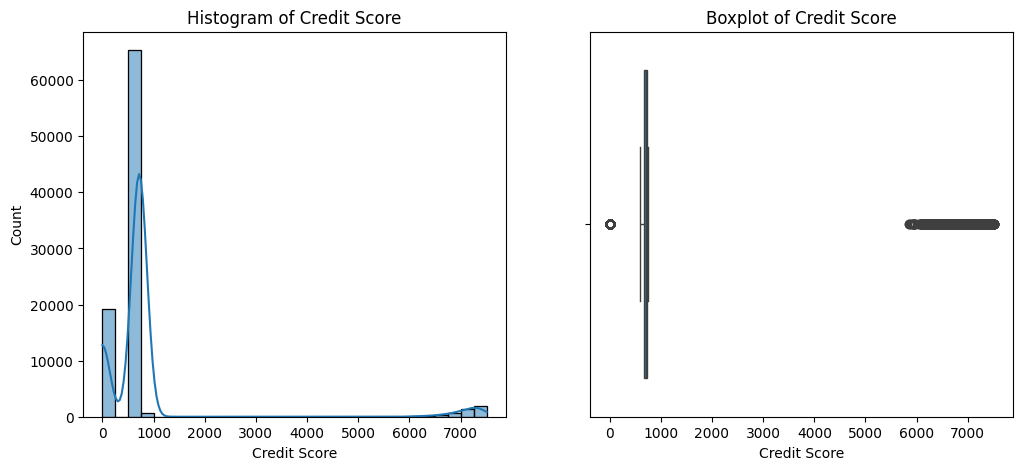

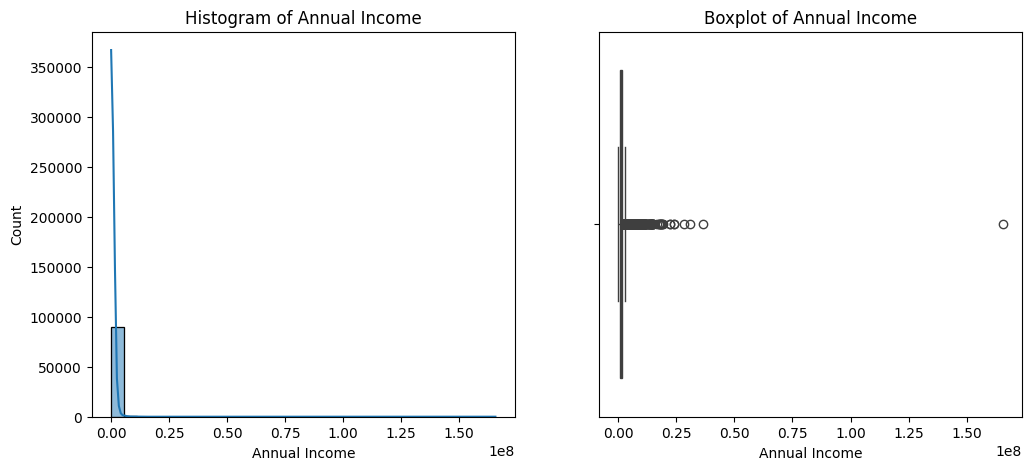

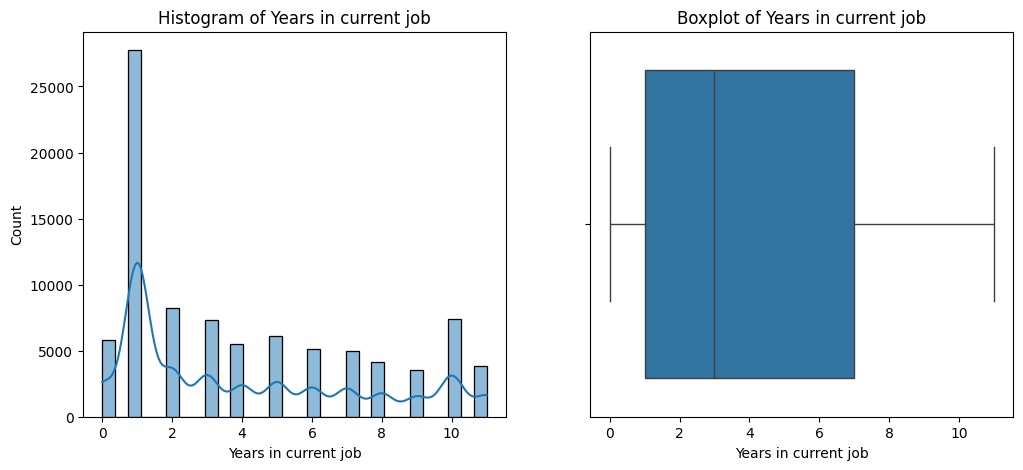

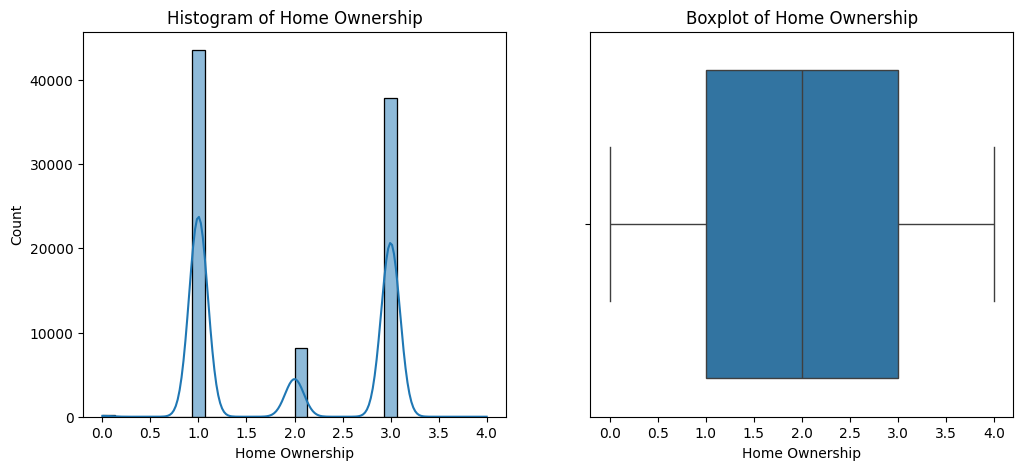

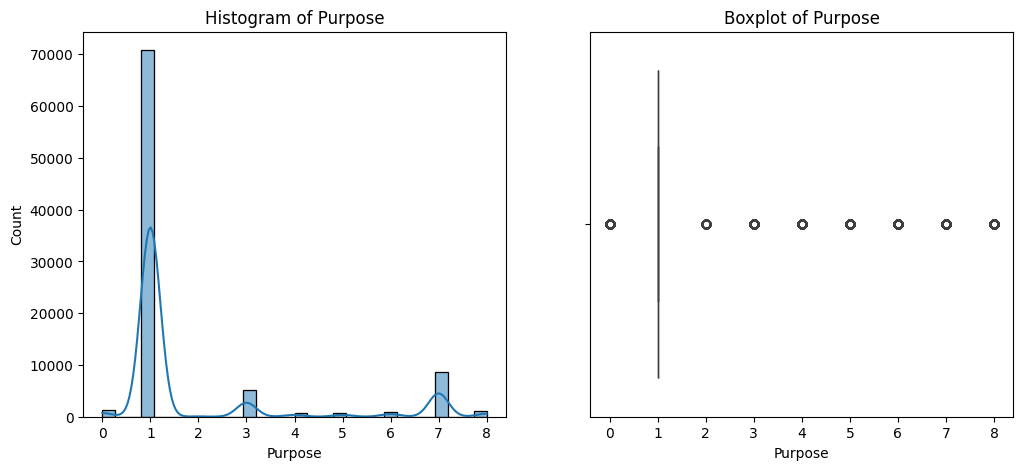

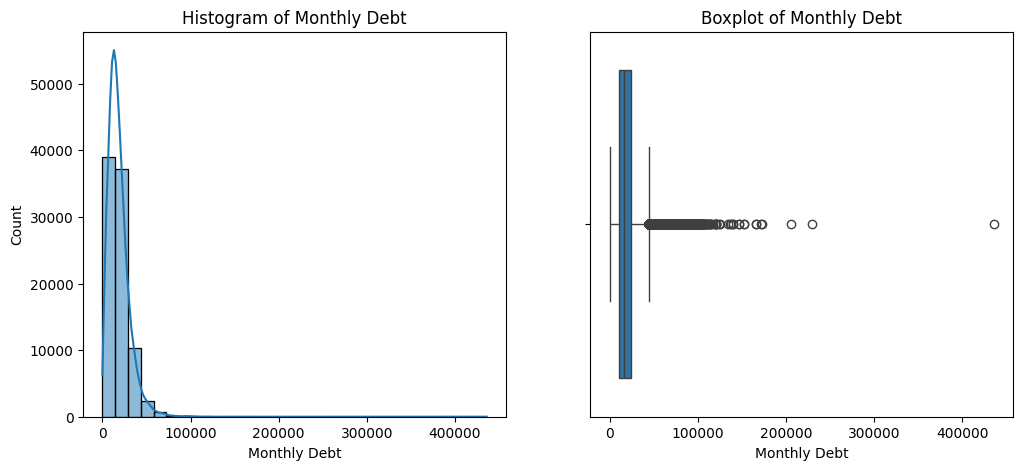

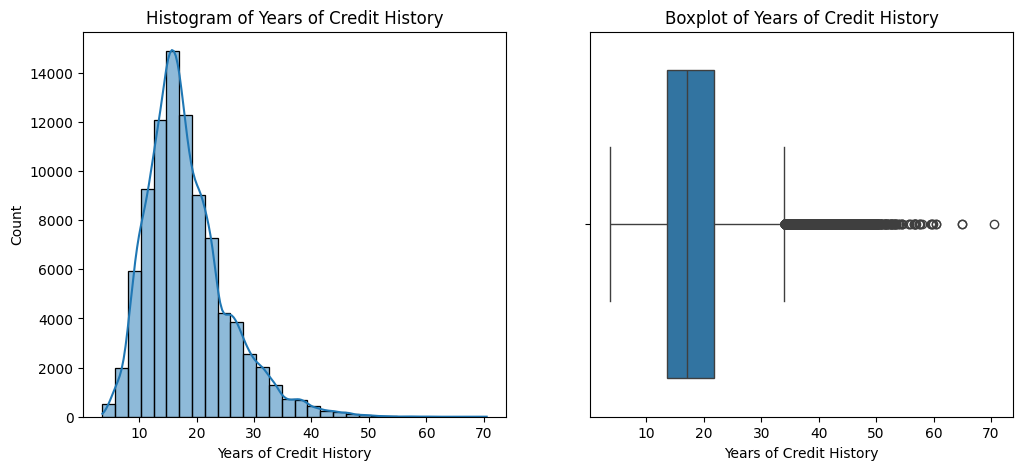

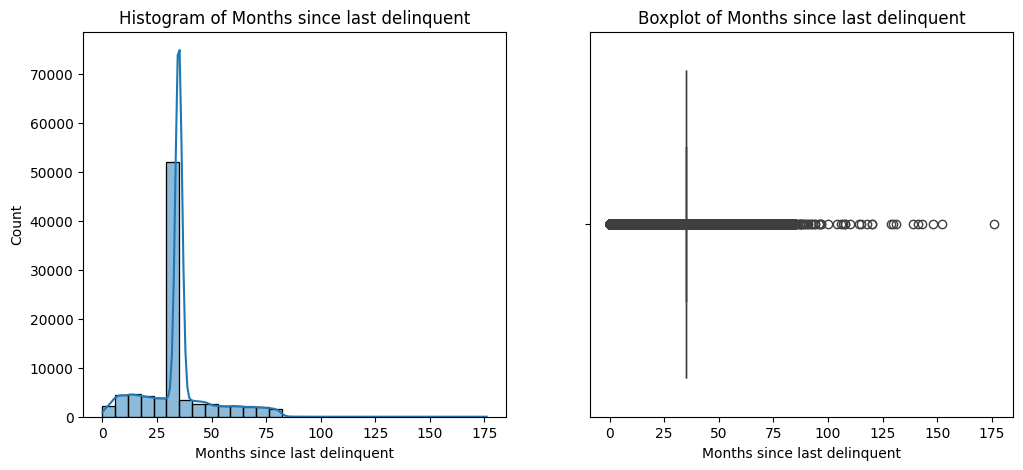

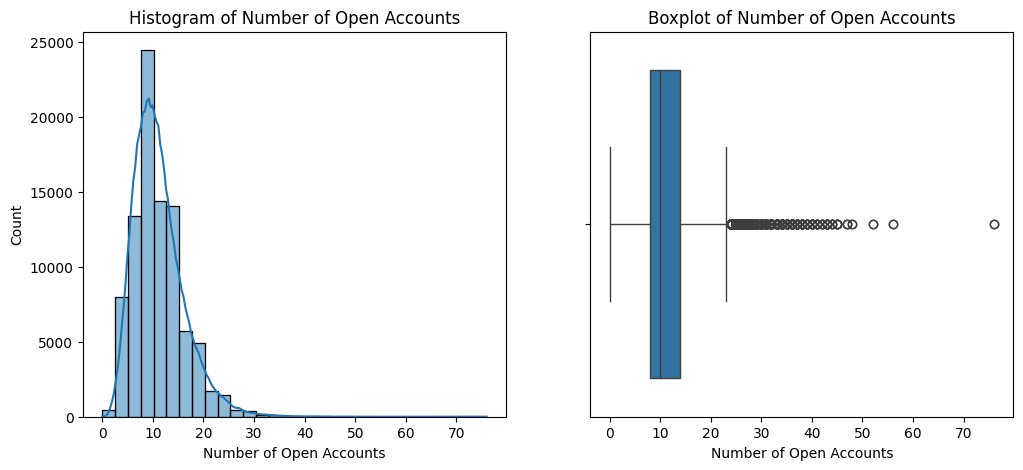

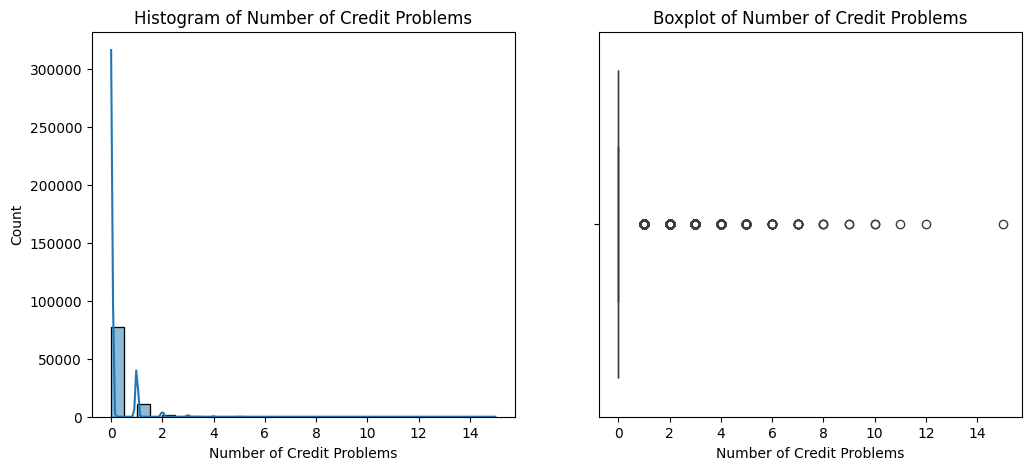

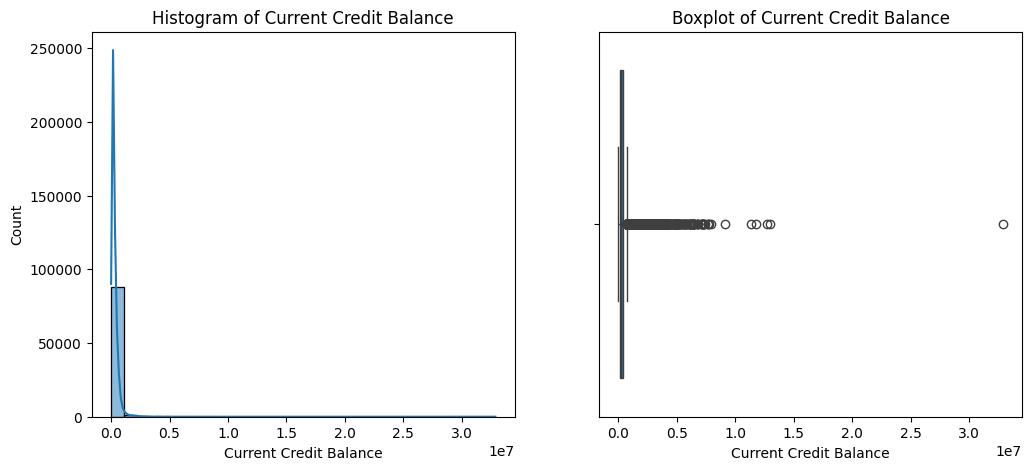

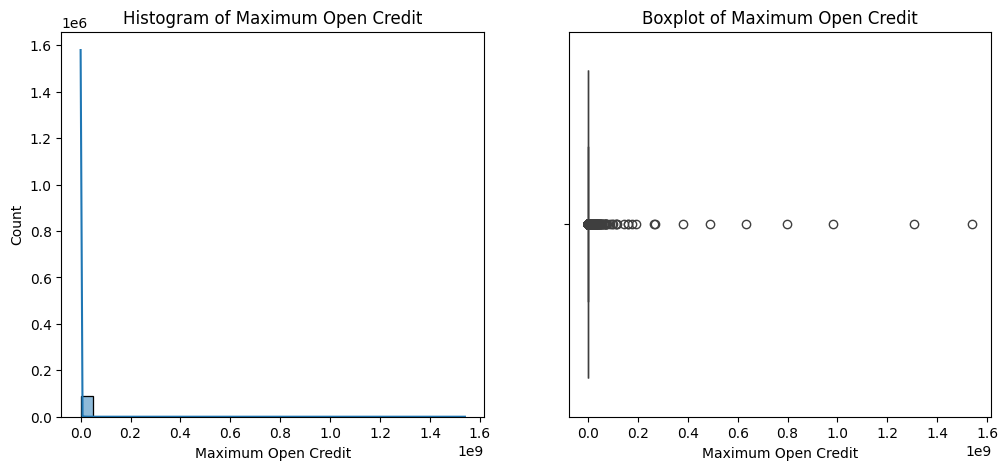

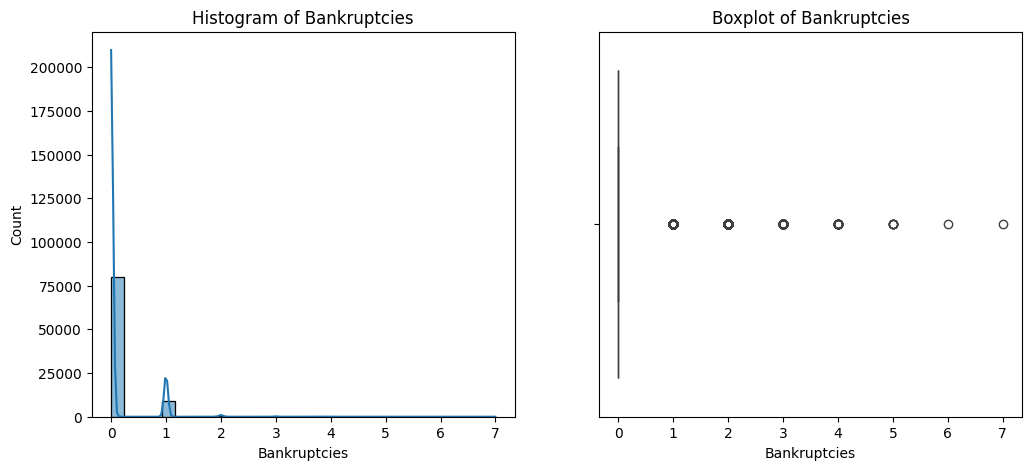

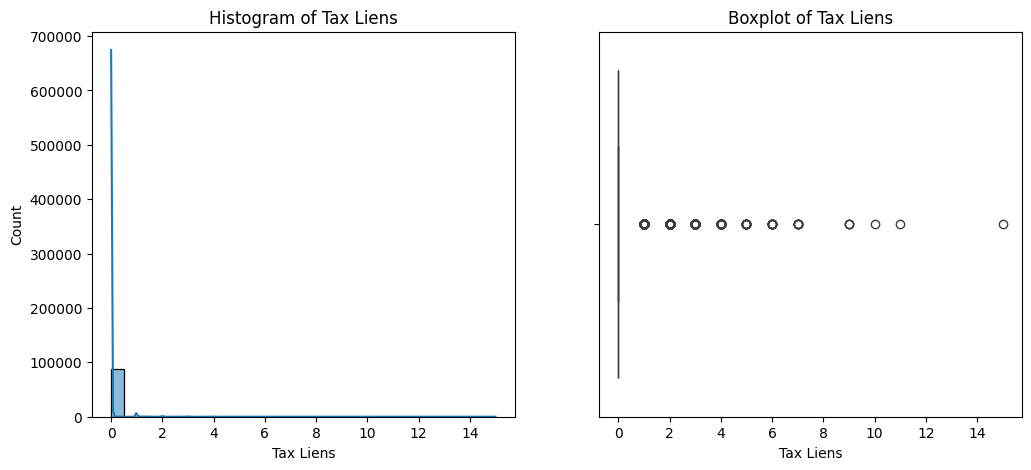

Correlation Matrix:


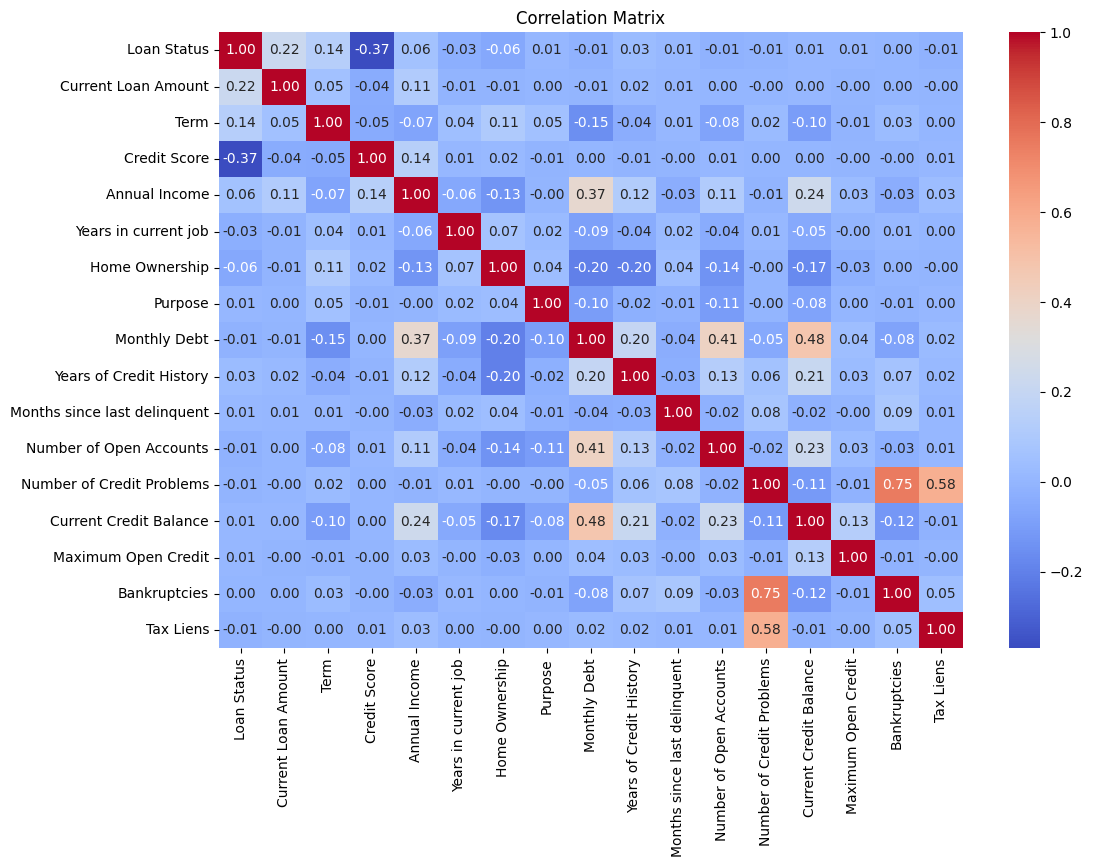

In [559]:
# Exploratory Data Analysis (EDA)
def perform_eda(df):
    print("EDA Summary")
    print(df.describe(include='all'))

    # Visualize numeric data
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_columns:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f"Histogram of {col}")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=df[col])
        plt.title(f"Boxplot of {col}")
        plt.show()

    # Visualize categorical data
    categorical_columns = df.select_dtypes(include=['category']).columns
    for col in categorical_columns:
        plt.figure(figsize=(12, 5))
        plt.subplot(1, 2, 1)
        sns.countplot(x=df[col], palette="viridis")
        plt.title(f"Countplot of {col}")
        plt.subplot(1, 2, 2)
        df[col].value_counts().plot.pie(autopct="%1.1f%%", startangle=90, colors=sns.color_palette("viridis"))
        plt.title(f"Pie Chart of {col}")
        plt.ylabel("")
        plt.show()
        
    # Correlation analysis
    print("Correlation Matrix:")
    correlation_matrix = df.corr()
    plt.figure(figsize=(12, 8))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
    plt.title("Correlation Matrix")
    plt.show()


perform_eda(df)

In [560]:
# Handle Outliers and Normalize Numeric Data
def process_numeric_columns(df):
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

    # Handle outliers
    for col in numeric_columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)

    # Normalize numeric data
    scaler = StandardScaler()
    df[numeric_columns] = scaler.fit_transform(df[numeric_columns])

    return df

df = process_numeric_columns(df)

EDA Summary
        Loan Status  Current Loan Amount          Term  Credit Score  \
count  8.978600e+04         8.978600e+04  8.978600e+04  8.978600e+04   
mean   8.863385e-17         2.279156e-17 -3.608664e-17 -1.299436e-16   
std    1.000006e+00         1.000006e+00  1.000006e+00  1.000006e+00   
min   -1.722154e+00        -1.299617e+00 -1.666852e+00 -1.709953e+00   
25%   -1.722154e+00        -7.423413e-01 -1.666852e+00 -3.254162e-01   
50%    5.805997e-01        -3.029887e-01  5.998647e-01  3.578618e-01   
75%    5.805997e-01         4.157069e-01  5.998647e-01  5.976085e-01   
max    2.883353e+00         2.152779e+00  2.866581e+00  1.982145e+00   

       Annual Income  Years in current job  Home Ownership  Purpose  \
count   8.978600e+04          8.978600e+04    8.978600e+04  89786.0   
mean   -2.532396e-17          4.771983e-17   -5.207239e-17      0.0   
std     1.000006e+00          1.000006e+00    1.000006e+00      0.0   
min    -1.322662e+00         -1.183068e+00   -2.025540e

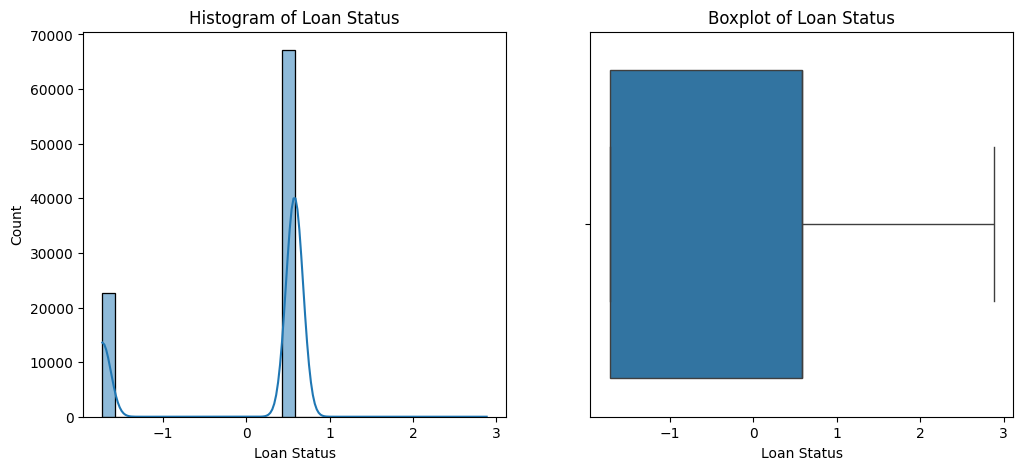

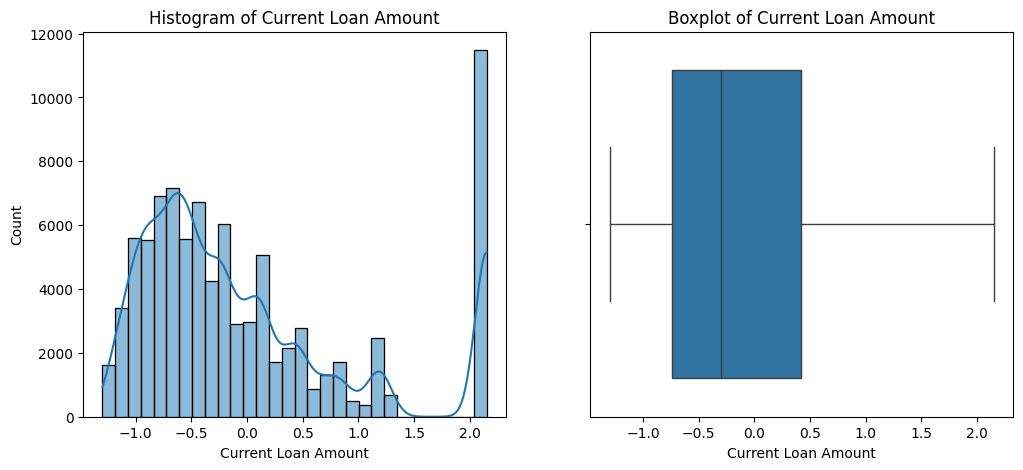

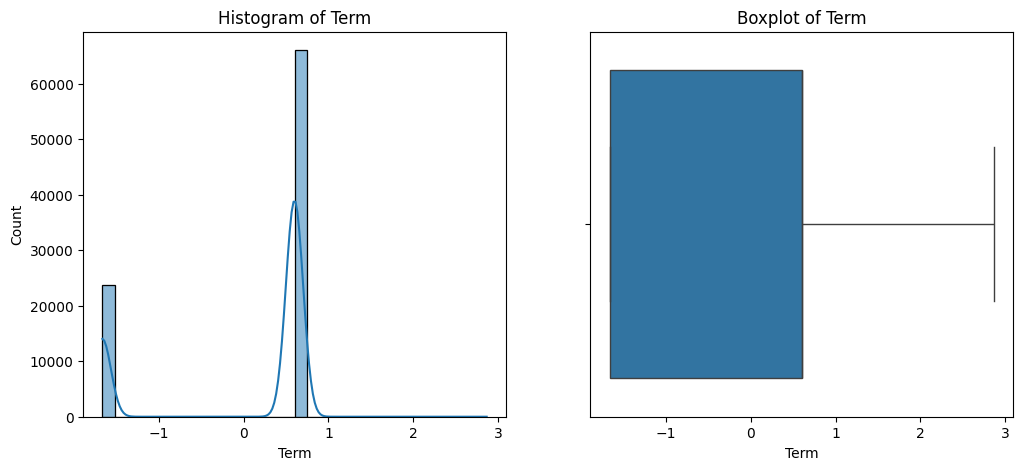

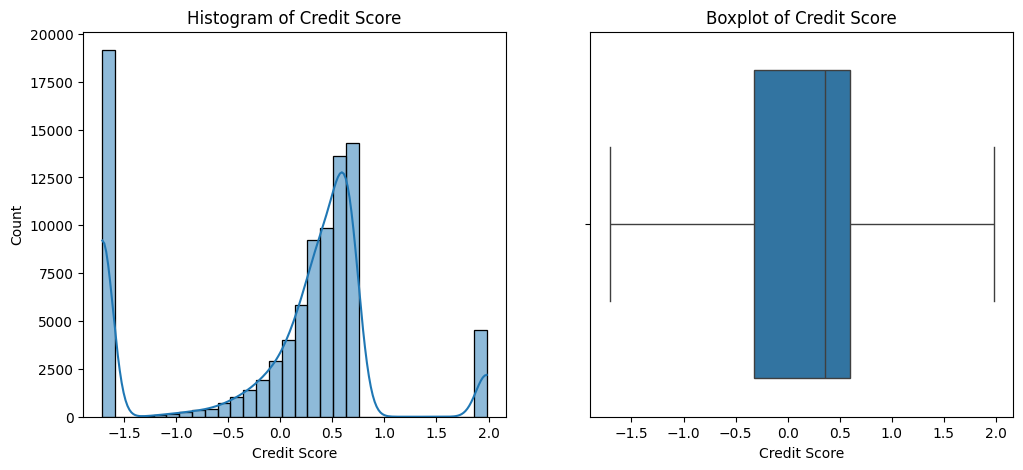

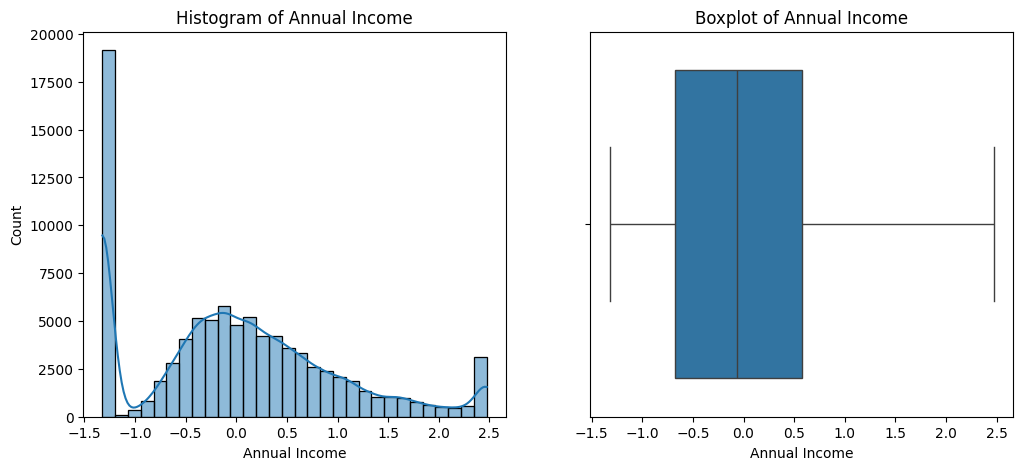

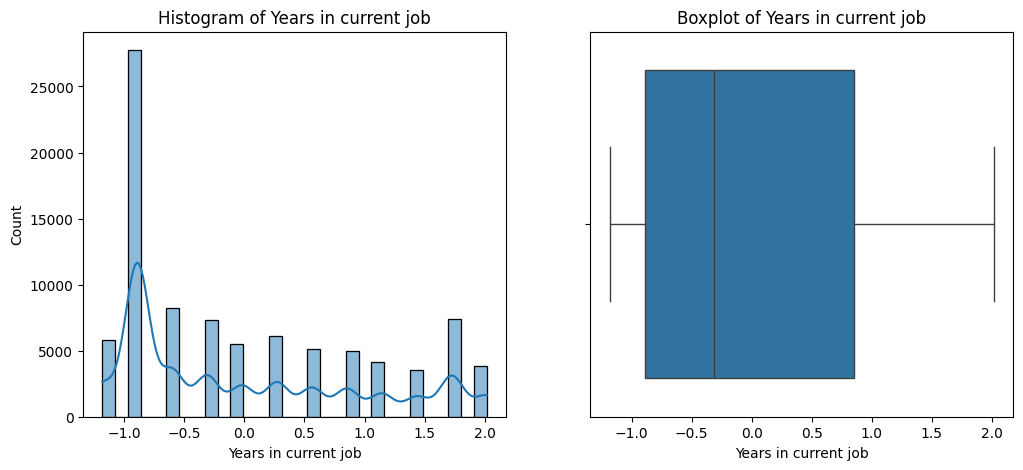

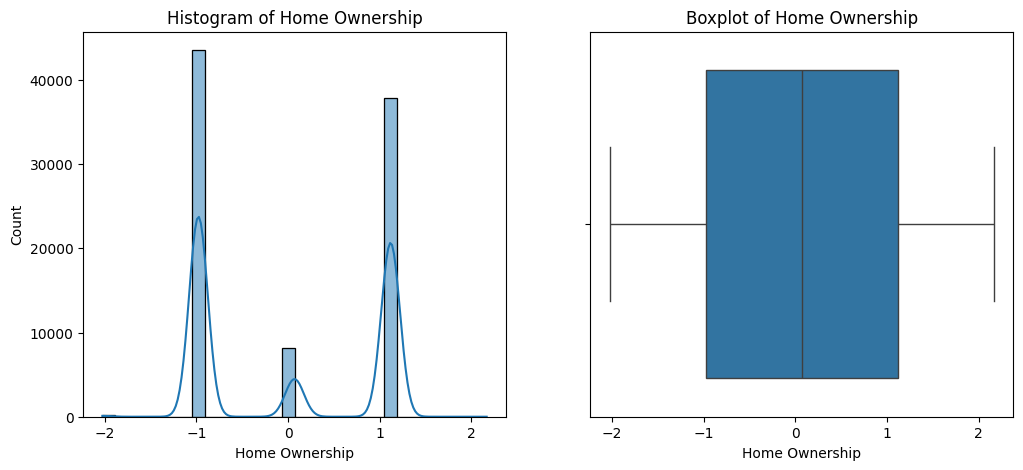

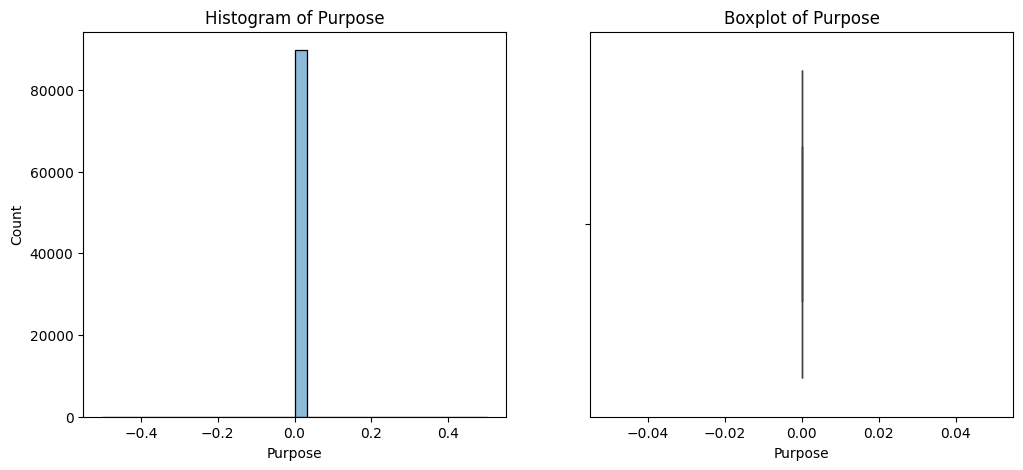

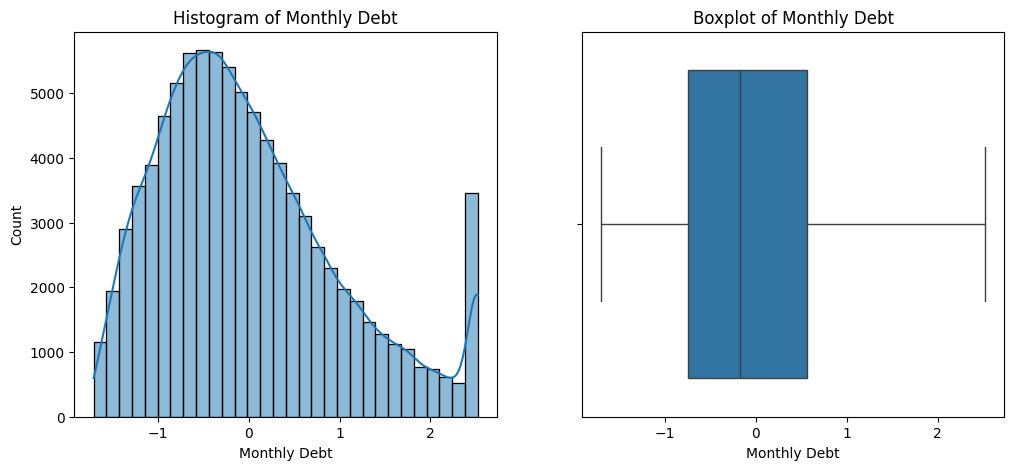

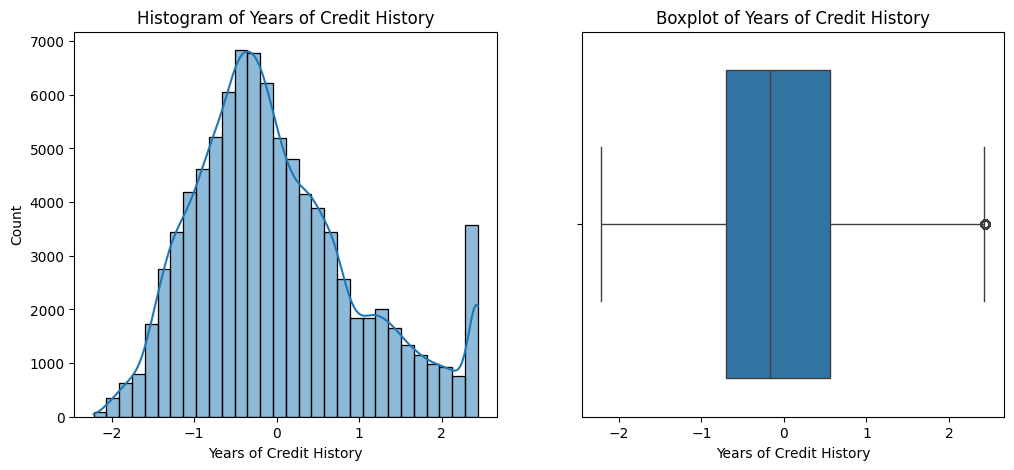

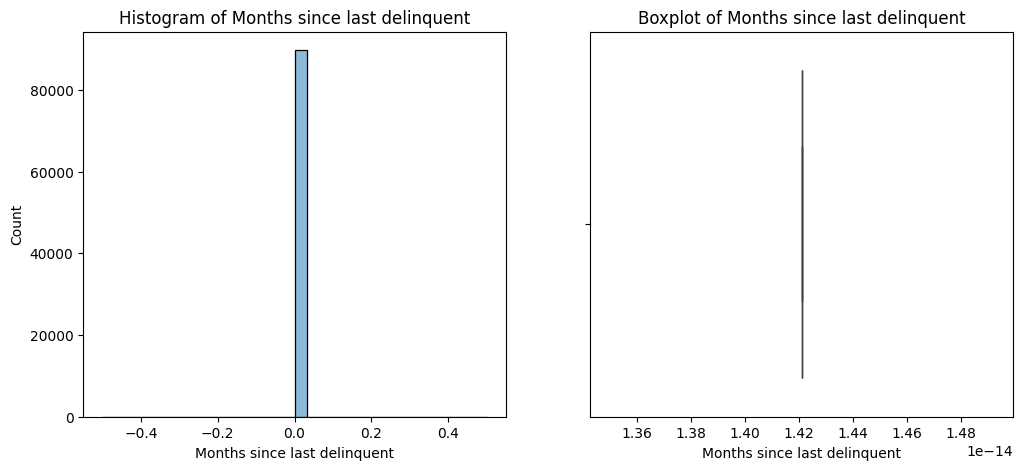

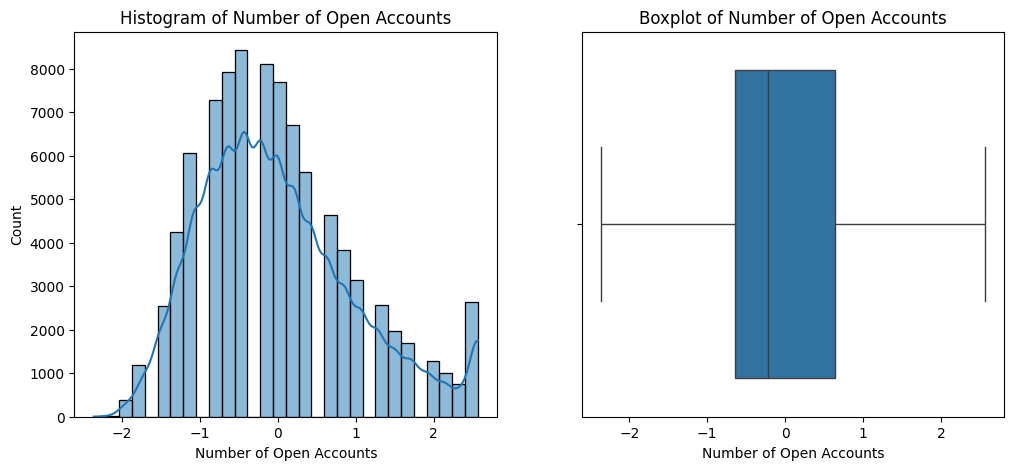

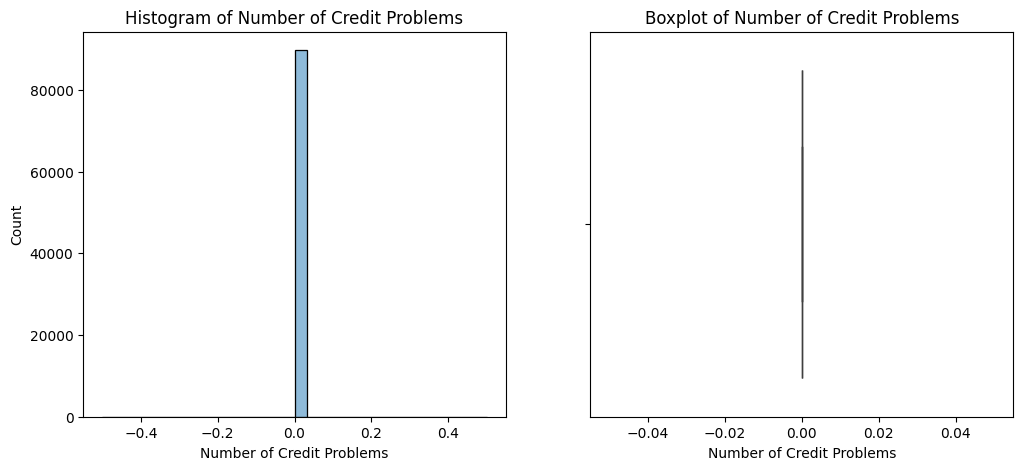

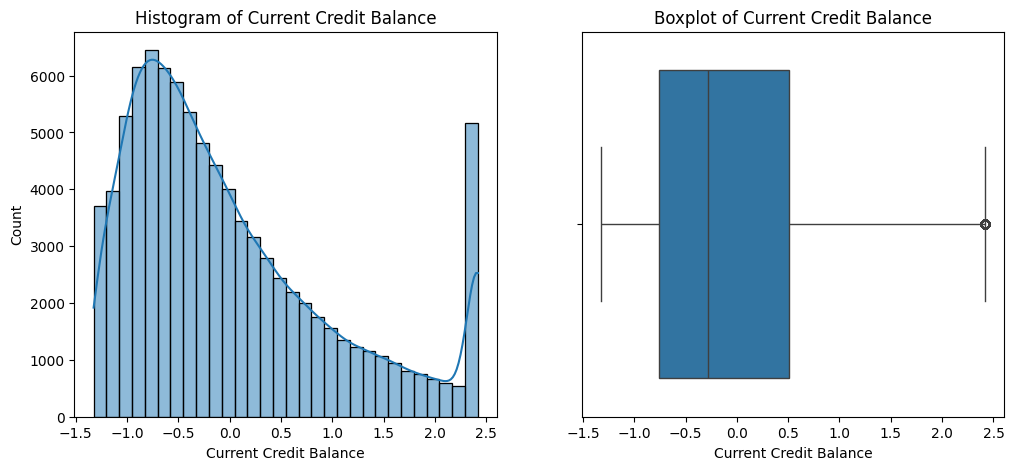

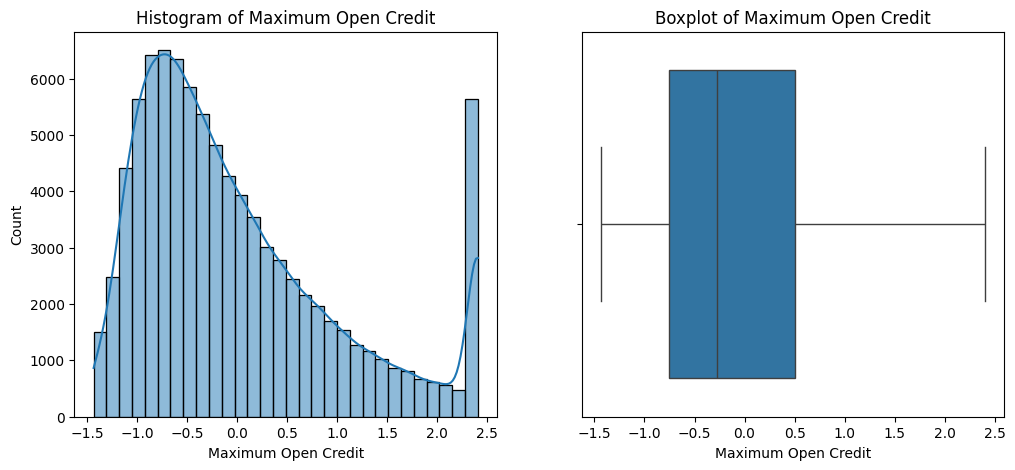

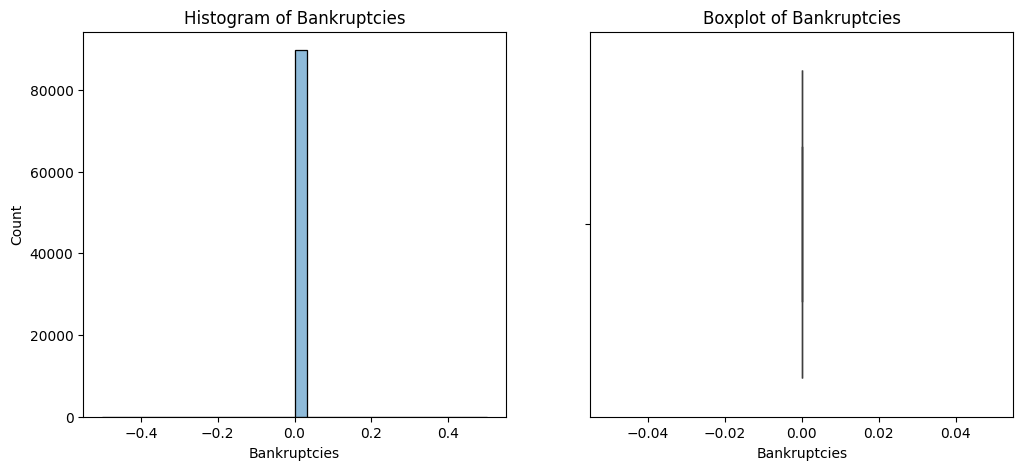

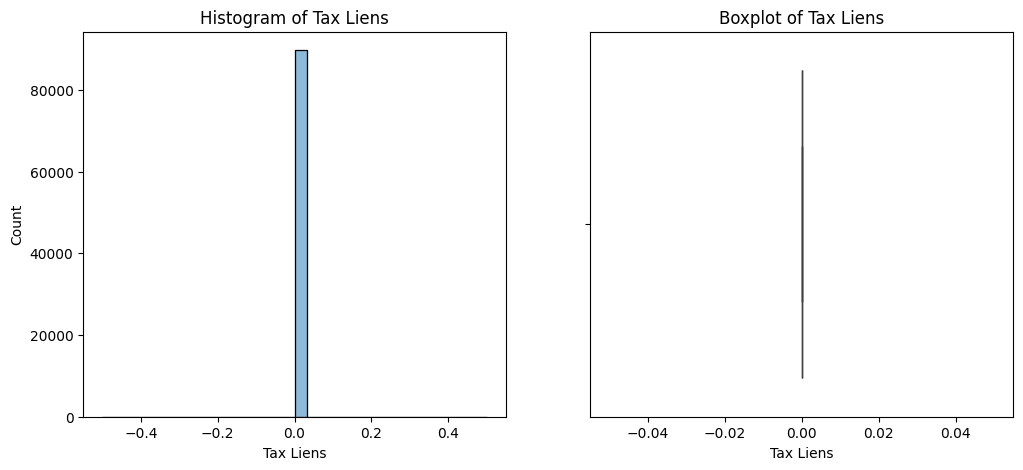

Correlation Matrix:


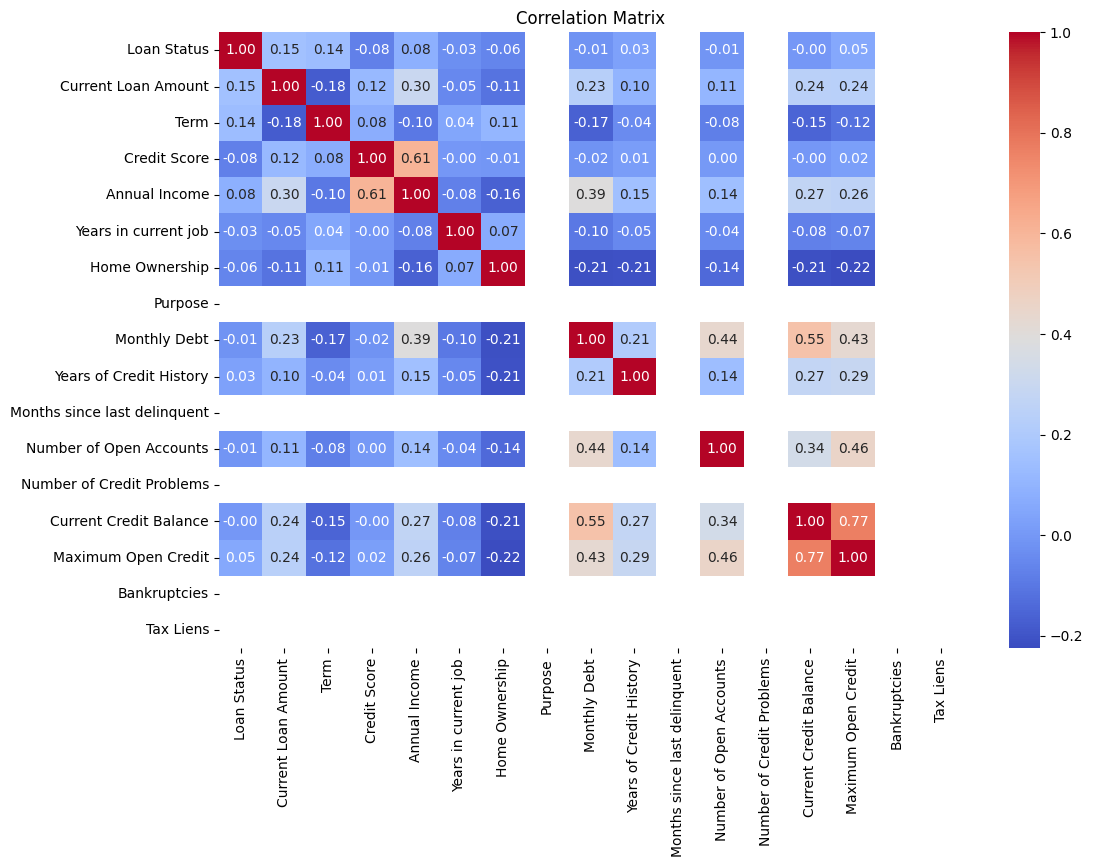

In [561]:
# Exploratory Data Analysis (EDA)
perform_eda(df)

In [562]:
columns_to_drop = ['Tax Liens', 'Bankruptcies', 'Number of Credit Problems', 'Months since last delinquent', 'Purpose']

In [563]:
# Dimensionality Reduction using PCA
def reduce_dimensions(df, n_components=2):
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(df)
    explained_variance = np.sum(pca.explained_variance_ratio_)
    print(f"Explained Variance by {n_components} components: {explained_variance:.2f}")
    return reduced_data

reduced_data = reduce_dimensions(df)

Explained Variance by 2 components: 0.39


In [564]:
# Perform Clustering with DBSCAN
def perform_clustering(data, eps=0.5, min_samples=5):
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(data)

    if len(set(cluster_labels)) > 1:
        silhouette_avg = silhouette_score(data, cluster_labels)
        print(f"Silhouette Score: {silhouette_avg}")
    else:
        print("Only one cluster found. Silhouette Score cannot be calculated.")

    return cluster_labels

cluster_labels = perform_clustering(reduced_data, eps=0.5, min_samples=5)

Silhouette Score: 0.3899776893711724


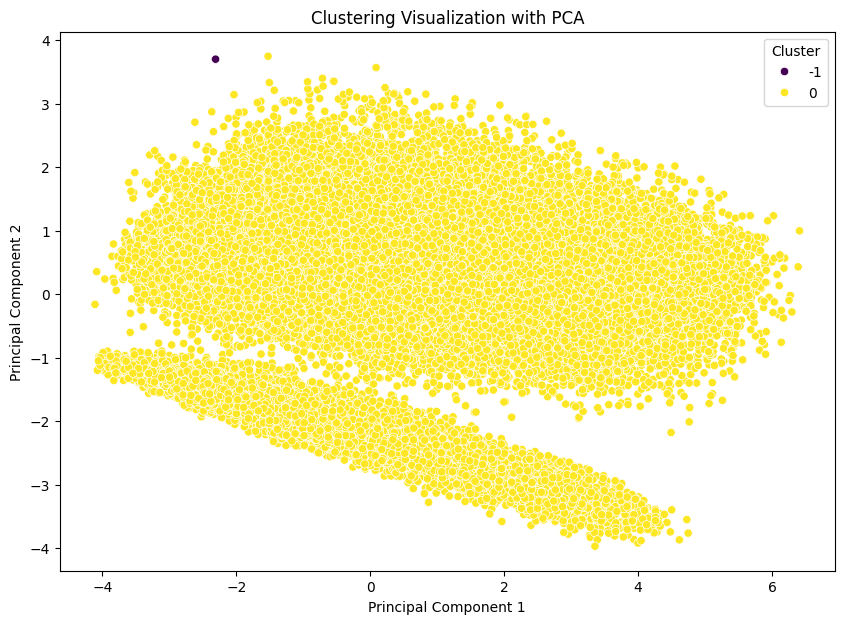

In [565]:
# Visualize Clustering
def visualize_clusters(data, cluster_labels):
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=data[:, 0], y=data[:, 1], hue=cluster_labels, palette="viridis", legend="full")
    plt.title("Clustering Visualization with PCA")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Cluster")
    plt.show()

visualize_clusters(reduced_data, cluster_labels)


In [566]:

print("Processing complete.")

Processing complete.
